In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(output_folder, 'dynamic.h5'))

In [5]:
# Assign window indices for each branch between 0 to 193 (the indices are in increasing order of time)
pb_window_indices = list(range(100, 144)) + [2] #left out starting 98 and ending 146th window to make the number of windows equal to GC
abc_window_indices = [1] + list(range(97, 3, -1)) + [0]
gc_window_indices = list(range(150, 194)) + [3]
pb_with_actb_indices = abc_window_indices + pb_window_indices
gc_with_actb_indices = abc_window_indices + gc_window_indices

# Discover early to late peaking TFs through regulatory curve characteristics

PlasmaBlast


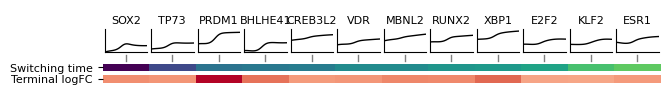

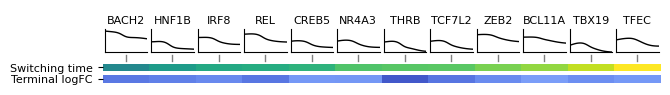

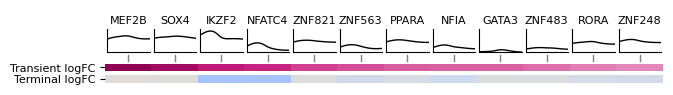

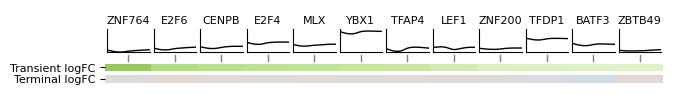

GerminalCenter


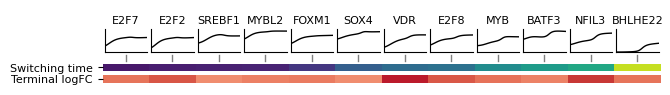

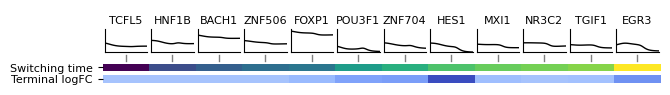

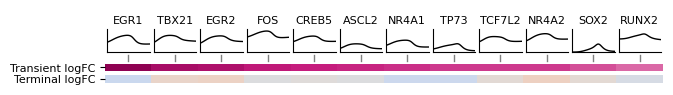

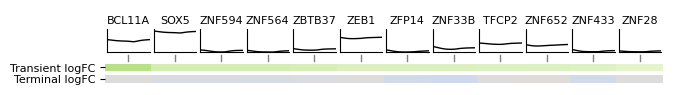

In [7]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
#See main1.ipynb
branches={
	'PlasmaBlast':(0,2),
	'GerminalCenter':(1,3)
}

for branchname in branches:
	print(branchname)
	figs=dictys_dynamic_object.draw_discover(*branches[branchname],ntops=(12,12,12,12),num=100,dist=0.0005,mode='TF_expression')
	plt.show()

# Visualize custom TFs

In [6]:
custom_tfs = ['BACH2','CREB3L2', 'NFKB1','TFEC','EP2','PRDM1','XBP1','PAX5','IRF4']
tf_indices_custom, tf_gene_indices_custom, missing_tfs = get_tf_indices(dictys_dynamic_object, custom_tfs)
display(tf_indices_custom)
display(missing_tfs) #not present in the motif databases, hence not in the final GRN. QC filtering has been masked for important genes to not dropout.

[16, 36, 187, 290, 225, 305, 208, 118]

['EP2']

In [15]:
custom_lf_pairs = [('PBX3','PAX5'),('RFX3','CEP128'),('CREB3L2','FNDC3A'),('CREB3L2','TXNDC5'),('CREB3L2','TRAM1'),('PAX5','RUNX2')]

In [44]:
custom_tf_links = [('IRF4','TCF4'),('IRF4','BCL11A'),('IRF4','PAX5'),('IRF4','RUNX2'),('SPIB','TCF4'),('SPIB','STAT1'),('SPIB','AHR'),('SPIB','KLF2'),('PRDM1','IKZF2'),('PRDM1','NR4A2'),('PRDM1','HNF1B'),('PRDM1','MYC'),('IRF4','MYC'),('PRDM1','IL2RA'),('PRDM1','CCND2'),('IRF4','CCND2'),('IRF4','IL2RA')]

In [8]:
def cluster_heatmap(d,
		optimal_ordering=True,
		method='ward',
		metric='euclidean',
		dshow=None,
		fig=None,
		cmap='coolwarm',
		aspect=0.1,
		figscale=0.02,
		dtop=0.3,
		dright=0,
		wcolorbar=0.03,
		wedge=0.03,
		xselect=None,
		yselect=None,
		xtick=False,
		ytick=True,
		vmin=None,
		vmax=None,
		inverty=True):
	"""
	Draw 2-D hierachical clustering of pandas.DataFrame, with optional hierachical clustering on both axes.
	X/Y axis of figure corresponds to columns/rows of the dataframe.
	d:		Pandas.DataFrame 2D data with index & column names for clustering.
	optimal_ordering: passed to scipy.cluster.hierarchy.dendrogram
	method: Method of hierarchical clustering, passed to scipy.cluster.hierarchy.linkage.
			Accepts single strs or a tuple of two strings for different method options for x and y.
	metric:	Metric to compute pariwise distance for clustering, passed to scipy.spatial.distance.pdist.
			Accepts single strs or a tuple of two strings for different metric options for x and y.
	dshow:	Pandas.DataFrame 2D data with index & column names to draw heatmap. Defaults to d.
	fig:	Figure to plot on.
	cmap:	Colormap
	aspect:	Aspect ratio
	figscale:	Scale of figure compared to font.
	dtop,
	dright:	Top and right dendrogram size. Value from 0 to 1 values as proportion.
			If 0, do not cluster on given axis.
	wcolorbar: Width of colorbar. Value from 0 to 1 values as proportion.
	wedge:	Width of edges and between colorbar and main figure.
			Value from 0 to 1 values as proportion.
	xselect,
	yselect:np.array(bool) of coordinates to draw. Current only selected coordinates are used for clustering.
			TODO: All coordinates in d are used for clustering.
	xtick,
	ytick:	Whether to show ticks.
	vmin,
	vmax:	Minimum/maximum values of heatmap.
	inverty:Whether to invert direction of y.
	Return:
	figure:	plt.Figure drawn on
	x:		column IDs included
	y:		index IDs included.
	"""
	import matplotlib.pyplot as plt
	from scipy.cluster.hierarchy import dendrogram, linkage
	import numpy as np
	assert isinstance(xtick,bool) or (isinstance(xtick,list) and len(xtick) == d.shape[1])
	assert isinstance(ytick,bool) or (isinstance(ytick,list) and len(ytick) == d.shape[0])
	if isinstance(method,str):
		method=[method,method]
	if len(method)!=2:
		raise ValueError('Parameter "method" must have size 2 for x and y respectively.')
	if isinstance(metric,str):
		metric=[metric,metric]
	if metric is not None and len(metric)!=2:
		raise ValueError('Parameter "metric" must have size 2 for x and y respectively.')
	if metric is None:
		assert d.ndim==2 and d.shape[0]==d.shape[1]
		assert (d.index==d.columns).all()
		assert method[0]==method[1]
		if xselect is not None:
			assert yselect is not None
			assert (xselect==yselect).all()
		else:
			assert yselect is None
	if dshow is None:
		dshow=d
	assert dshow.shape==d.shape and (dshow.index==d.index).all() and (dshow.columns==d.columns).all()
	xt0 = d.columns if isinstance(xtick,bool) else xtick
	yt0 = d.index if isinstance(ytick,bool) else ytick
	# Genes to highlight
	d2 = d.copy()
	if xselect is not None:
		d2 = d2.loc[:, xselect]
		dshow=dshow.loc[:,xselect]
		xt0 = [xt0[x] for x in np.nonzero(xselect)[0]]
	if yselect is not None:
		d2 = d2.loc[yselect]
		dshow=dshow.loc[yselect]
		yt0 = [yt0[x] for x in np.nonzero(yselect)[0]]

	wtop = dtop / (1 + d2.shape[0] / 8)
	wright = dright / (1 + d2.shape[1] * aspect / 8)
	iscolorbar = wcolorbar > 0
	t1 = np.array(d2.T.shape)
	t1 = t1 * figscale
	t1[1] /= aspect
	t1[1] /= 1 - wedge * 2 - wtop
	t1[0] /= 1 - wedge * (2 + iscolorbar) - wright - wcolorbar
	if fig is None:
		fig = plt.figure(figsize=t1)

	d3 = dshow.copy()
	if metric is not None:
		# Right dendrogram
		if dright > 0:
			ax1 = fig.add_axes([
				1 - wedge * (1 + iscolorbar) - wright - wcolorbar, wedge, wright,
				1 - 2 * wedge - wtop])
			tl1 = linkage(d2, method=method[1], metric=metric[1], optimal_ordering=optimal_ordering)
			td1 = dendrogram(tl1, orientation='right')
			ax1.set_xticks([])
			ax1.set_yticks([])
			d3 = d3.iloc[td1['leaves'], :]
			yt0 = [yt0[x] for x in td1['leaves']]
		else:
			ax1=None

		# Top dendrogram
		if dtop > 0:
			ax2 = fig.add_axes([wedge, 1 - wedge - wtop, 1 - wedge * (2 + iscolorbar) - wright - wcolorbar, wtop])
			tl2 = linkage(d2.T, method=method[0], metric=metric[0], optimal_ordering=optimal_ordering)
			td2 = dendrogram(tl2)
			ax2.set_xticks([])
			ax2.set_yticks([])
			d3 = d3.iloc[:, td2['leaves']]
			xt0 = [xt0[x] for x in td2['leaves']]
		else:
			ax2=None
	else:
		if dright > 0 or dtop > 0:
			from scipy.spatial.distance import squareform
			tl1 = linkage(squareform(d2), method=method[0], optimal_ordering=optimal_ordering)
			# Right dendrogram
			if dright > 0:
				ax1 = fig.add_axes([
					1 - wedge * (1 + iscolorbar) - wright - wcolorbar, wedge, wright,
					1 - 2 * wedge - wtop])
				td1 = dendrogram(tl1, orientation='right')
				ax1.set_xticks([])
				ax1.set_yticks([])
			else:
				ax1=None
				td1=None
			# Top dendrogram
			if dtop > 0:
				ax2 = fig.add_axes([wedge, 1 - wedge - wtop, 1 - wedge * (2 + iscolorbar) - wright - wcolorbar, wtop])
				td2 = dendrogram(tl1)
				ax2.set_xticks([])
				ax2.set_yticks([])
			else:
				ax2=None
				td2=None
			td0=td1['leaves'] if td1 is not None else td2['leaves']
			d3 = d3.iloc[td0,:].iloc[:,td0]
			xt0,yt0 = [[y[x] for x in td0] for y in [xt0,yt0]]
	axmatrix = fig.add_axes([
		wedge, wedge, 1 - wedge * (2 + iscolorbar) - wright - wcolorbar,
		1 - 2 * wedge - wtop])
	ka = {'aspect': 1 / aspect, 'origin': 'lower', 'cmap': cmap}
	if vmin is not None:
		ka['vmin'] = vmin
	if vmax is not None:
		ka['vmax'] = vmax
	im = axmatrix.matshow(d3, **ka)
	if not isinstance(xtick,bool) or xtick:
		t1 = list(zip(range(d3.shape[1]), xt0))
		t1 = list(zip(*list(filter(lambda x: x[1] is not None, t1))))
		axmatrix.set_xticks(t1[0])
		axmatrix.set_xticklabels(t1[1], minor=False, rotation=90)
	else:
		axmatrix.set_xticks([])
	if not isinstance(ytick,bool)or ytick:
		t1 = list(zip(range(d3.shape[0]), yt0))
		t1 = list(zip(*list(filter(lambda x: x[1] is not None, t1))))
		axmatrix.set_yticks(t1[0])
		axmatrix.set_yticklabels(t1[1], minor=False)
	else:
		axmatrix.set_yticks([])

	axmatrix.tick_params(top=False,
		bottom=True,
		labeltop=False,
		labelbottom=True,
		left=True,
		labelleft=True,
		right=False,
		labelright=False)
	if inverty:
		if ax1 is not None:
			ax1.set_ylim(ax1.get_ylim()[::-1])
		axmatrix.set_ylim(axmatrix.get_ylim()[::-1])
	if wcolorbar > 0:
		cax = fig.add_axes([
			1 - wedge - wcolorbar, wedge, wcolorbar, 1 - 2 * wedge - wtop])
		fig.colorbar(im, cax=cax)

	return fig, d3.columns, d3.index

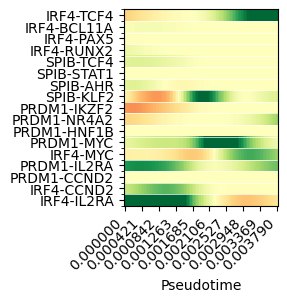

In [45]:
# plot the heatmap of the cell-cycle pairs
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=custom_tf_links,
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [17]:
print("Original dnet values range:", dnet.min(), "to", dnet.max())

Original dnet values range: -0.020861984380826454 to 0.4124681628636079


In [42]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in custom_tf_links])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.054579133260743096 to 0.13086331960536934


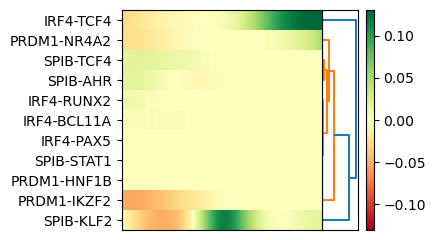

In [43]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

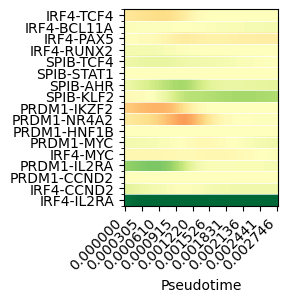

In [46]:
# plot the heatmap of the cell-cycle pairs
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=custom_tf_links,
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [13]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in custom_lf_pairs])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.10806886377985477 to 0.2892437664542025


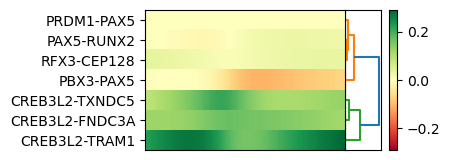

In [14]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

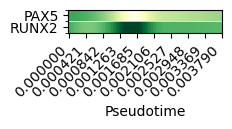

In [46]:
# plot expression gradient of RUNX2
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=['PAX5', 'RUNX2'],
    num=100,
    dist=0.0005,
    cmap='YlGn' # green is positive yellow is negative
)


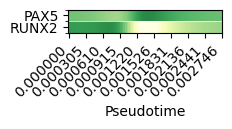

In [47]:
# plot expression gradient of RUNX2
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=['PAX5', 'RUNX2'],
    num=100,
    dist=0.0005,
    cmap='YlGn' # green is positive yellow is negative
)


#### PB branch compute chars

In [18]:
# get line plots for pax5, runx2
# Call compute_chars for expression mode
dy_pb, dx_pb = compute_curves(dictys_dynamic_object,
    start=0,          # Starting node ID
    stop=2,           # Ending node ID
    num=100,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)


In [21]:
# Calculate gradients for all genes
gradients_df_pb = pd.DataFrame(
    np.vstack([np.gradient(dy_pb.loc[gene].values, dx_pb.values) for gene in dy_pb.index]),
    columns=dy_pb.columns,
    index=dy_pb.index
)

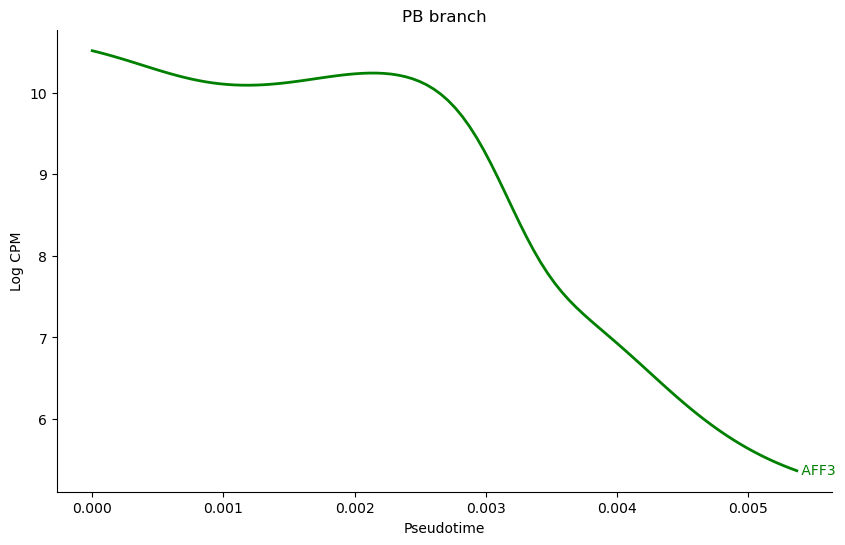

In [20]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['AFF3']
colors = ['green']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_pb.index:
        line = plt.plot(dx_pb, dy_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dx_pb.iloc[-1], dy_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('PB branch')
plt.show()

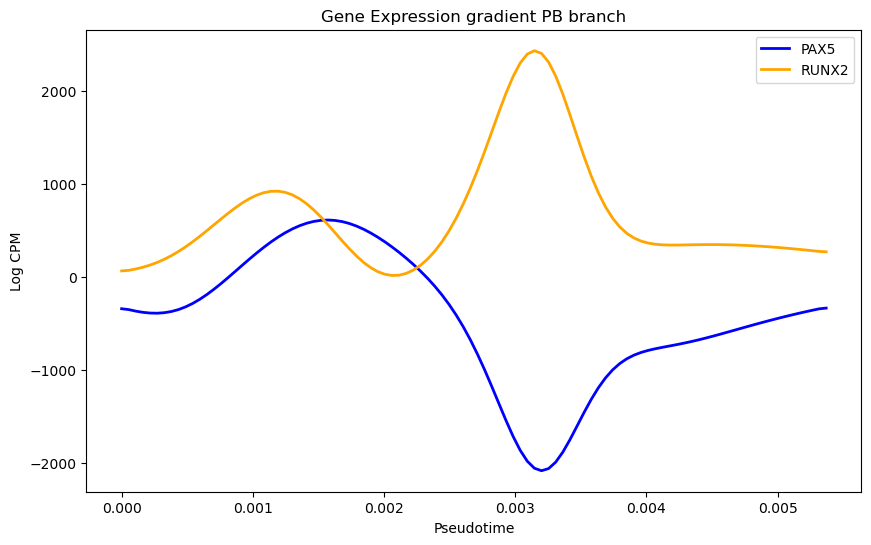

In [24]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PAX5', 'RUNX2']
colors = ['blue', 'orange']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df_pb.index:
        plt.plot(dx_pb, gradients_df_pb.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression gradient PB branch')
plt.legend()
plt.show()

#### GC branch compute chars

In [21]:
dy_gc, dx_gc = compute_curves(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=3,           # Ending node ID
    num=100,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM)/ regulation (target counts) mode
)


In [8]:
# Calculate gradients for all genes
gradients_df_gc = pd.DataFrame(
    np.vstack([np.gradient(dy_gc.loc[gene].values, dx_gc.values) for gene in dy_gc.index]),
    columns=dy_gc.columns,
    index=dy_gc.index
)

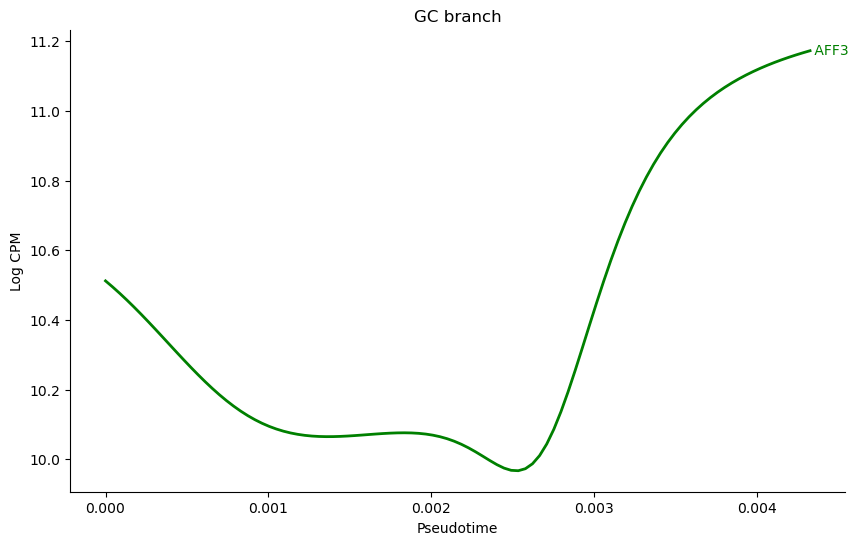

In [23]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

genes_of_interest = ['AFF3']
colors = ['green'] # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_gc.index:
        line = plt.plot(dx_gc, dy_gc.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dx_gc.iloc[-1], dy_gc.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')
plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('GC branch')
plt.show()

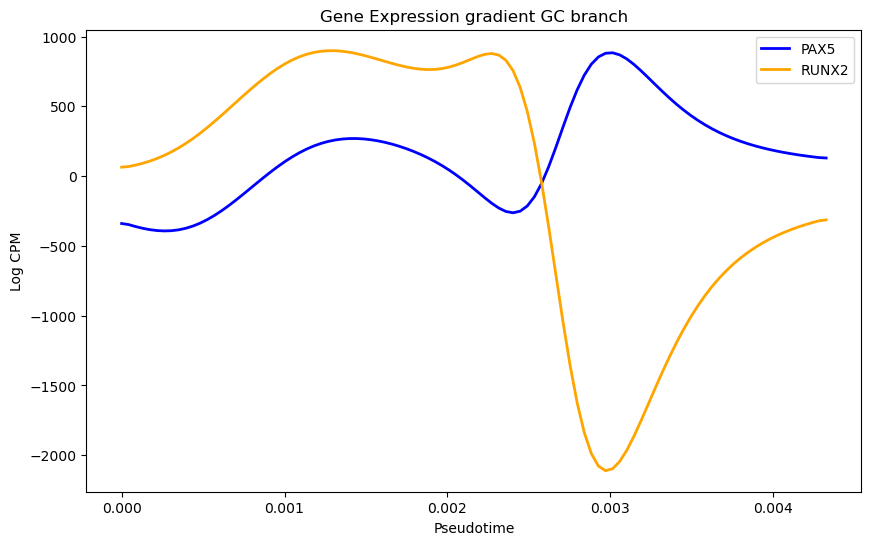

In [28]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PAX5', 'RUNX2']
colors = ['blue', 'orange']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df_gc.index:
        plt.plot(dx_gc, gradients_df_gc.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression gradient GC branch')
plt.legend()
plt.show()

# Get pairs that are divergent in regulating PB and GC branches

In [10]:
# Get weights and indices for both branches
all_edges_pb = get_grn_weights_for_windows(
    dictys_dynamic_object, 
    window_indices=pb_window_indices, 
    nonzero_fraction_threshold=0.1
)

all_edges_gc = get_grn_weights_for_windows(
    dictys_dynamic_object, 
    window_indices=gc_window_indices, 
    nonzero_fraction_threshold=0.1
)

display(all_edges_pb.shape)
display(np.min(all_edges_pb))
display(np.max(all_edges_pb))
display(all_edges_gc.shape)
display(np.min(all_edges_gc))
display(np.max(all_edges_gc))

Output shape: (551, 11907, 48) n_windows=48)
Output shape: (551, 11907, 48) n_windows=48)


(551, 11907, 48)

np.float64(-49.84966701163342)

np.float64(39.64918125104784)

(551, 11907, 48)

np.float64(-116.88110098945694)

np.float64(113.3182659321968)

In [15]:
# Example usage:
# Calculate similarities
similarity_matrix = create_edge_similarity_matrix(
    all_edges_gc, 
    all_edges_pb, 
    method='fft'
)
display(similarity_matrix.shape)
display(similarity_matrix.todense())

/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


(551, 11907)

matrix([[0.84046242, 0.90505413, 0.        , ..., 0.        , 0.84070262,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.89202714, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [16]:
# save the similarity matrix as npz
np.savez('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/link_fft_similarity_GC_PB.npz', similarity_matrix=similarity_matrix)


In [47]:
# intersect the LF with the similarity matrix by slicing out the TF and target indices of the LF genes
#1. get the TF indices of the LF genes
tf_indices_lf, tf_gene_indices_lf, _ = get_tf_indices(dictys_dynamic_object, significant_latent_factors_genes)
# get the name of tf genes from ndict by finding keys with matching values
tf_names_lf = [gene for gene, idx in dictys_dynamic_object.ndict.items() if idx in tf_gene_indices_lf]
#2. get the target indices of the LF genes
target_indices_lf = get_target_indices(dictys_dynamic_object, significant_latent_factors_genes)
display(tf_names_lf)
display(len(target_indices_lf))


[np.str_('IRF4'),
 np.str_('PAX5'),
 np.str_('PRDM1'),
 np.str_('RUNX2'),
 np.str_('XBP1')]

57

In [50]:
#3. slice out the similarity matrix
similarity_matrix_lf = similarity_matrix.tocsr()[:, target_indices_lf]
display(similarity_matrix_lf.shape)

(551, 57)

In [51]:
divergent_edges = get_divergent_edges(
    similarity_matrix_lf, 
    dictys_dynamic_object,
    n_top=10
)
display(divergent_edges)

,TF_idx,Target_idx,TF_name,Target_name,Similarity_score
0,361,26,ZNF18,ABCB4,0.0
1,361,40,ZNF18,ABCE1,0.0
2,361,39,ZNF18,ABCD4,0.0
3,361,38,ZNF18,ABCD3,0.0
4,361,37,ZNF18,ABCD2,0.0
5,361,36,ZNF18,ABCD1,0.0
6,361,35,ZNF18,ABCC5,0.0
7,361,34,ZNF18,ABCC4,0.0
8,361,33,ZNF18,ABCC2,0.0
9,361,32,ZNF18,ABCC11,0.0


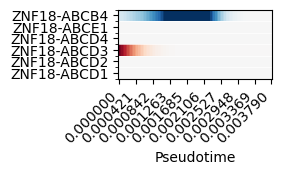

In [52]:
# draw the heatmap of the divergent edges
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=[('ZNF18','ABCB4'),('ZNF18','ABCE1'),('ZNF18','ABCD4'),('ZNF18','ABCD3'),('ZNF18','ABCD2'),('ZNF18','ABCD1')],
    num=100,
    dist=0.0005,
    cmap='RdBu'
)


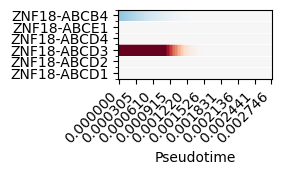

In [53]:
# draw the heatmap of the divergent edges
fig, ax, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=[('ZNF18','ABCB4'),('ZNF18','ABCE1'),('ZNF18','ABCD4'),('ZNF18','ABCD3'),('ZNF18','ABCD2'),('ZNF18','ABCD1')],
    num=100,
    dist=0.0005,
    cmap='RdBu'
)


# Animations


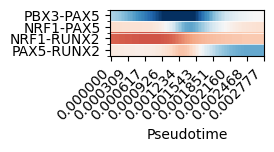

In [81]:
# plot the heatmap of the lineage pairs
fig, ax_gc, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=cell_cycle_pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

In [82]:
# Get the raw data from heatmap
heatmap_data_gc = ax_gc.images[0].get_array()

# Get unique TFs and targets from cell_cycle_pairs
tfs_gc = list(set(pair[0] for pair in cell_cycle_pairs))
targets_gc = list(set(pair[1] for pair in cell_cycle_pairs))

# Function to convert RdBu colors to regulation strength
def rdbu_to_regulation(rgb_values):
    # In RdBu, red indicates positive regulation (R > B)
    # and blue indicates negative regulation (B > R)
    return rgb_values[:, 0] - rgb_values[:, 2]  # R - B gives regulation strength

# Create a dictionary to store actual regulation values
regulation_dict_gc = {}
for row_idx, (tf, target) in enumerate(cell_cycle_pairs):
    # Convert RGB values to regulation strength
    regulation_strength = rdbu_to_regulation(heatmap_data_gc[row_idx])
    regulation_dict_gc[(tf, target)] = regulation_strength

# Create 3D array (n_tf x n_target x n_timepoints)
regulation_array_gc = np.zeros((len(tfs_gc), len(targets_gc), heatmap_data_gc.shape[1]))
for tf_idx, tf in enumerate(tfs_gc):
    for target_idx, target in enumerate(targets_gc):
        if (tf, target) in regulation_dict_gc:
            regulation_array_gc[tf_idx, target_idx, :] = regulation_dict_gc[(tf, target)]

print("\nFinal array shape:", regulation_array_gc.shape)
print("TFs:", tfs_gc)
print("Targets:", targets_gc)

Regulation PBX3->PAX5:
[-0.21153403 -0.22537486 -0.23921569 -0.25305652 -0.25997693] ... (first 5 timepoints)
Regulation NRF1->PAX5:
[0.18685121 0.17854671 0.17854671 0.17854671 0.17024221] ... (first 5 timepoints)
Regulation NRF1->RUNX2:
[0.5337178 0.5337178 0.5337178 0.5372549 0.5372549] ... (first 5 timepoints)
Regulation PAX5->RUNX2:
[0.10380623 0.10380623 0.09550173 0.09550173 0.09550173] ... (first 5 timepoints)

Final array shape: (3, 2, 100)
TFs: ['PBX3', 'PAX5', 'NRF1']
Targets: ['PAX5', 'RUNX2']


#### animate the sub-graph

In [89]:
# get the weights of the lineage pairs across windows
tf_indices_lineage, tf_gene_indices_lineage = get_tf_indices(dictys_dynamic_object, [pair[0] for pair in lineage_pairs])
gene_indices_lineage = get_target_gene_indices(dictys_dynamic_object, [pair[1] for pair in lineage_pairs])


In [87]:
import networkx as nx
import matplotlib.animation as animation
from matplotlib.patches import ArrowStyle, ConnectionStyle
import matplotlib.pyplot as plt

def create_network_animation(weights, tf_names, target_names, output_path, branch_name):
    """
    Create and save network animation showing weight changes across windows.
    Node positions remain fixed, only edge weights change.
    """
    n_tfs, n_targets, n_windows = weights.shape
    
    # Create initial graph with all possible nodes and edges
    G_init = nx.DiGraph()
    
    # Add TF nodes
    for tf in tf_names:
        G_init.add_node(tf, node_type='TF')
        
    # Add target nodes
    for target in target_names:
        G_init.add_node(target, node_type='target')
    
    # Calculate fixed layout once
    pos = nx.spring_layout(G_init, k=1, iterations=50)
    
    def create_graph(window_idx):
        G = G_init.copy()
        
        # Add edges with weights for this window
        for i, tf in enumerate(tf_names):
            for j, target in enumerate(target_names):
                weight = weights[i, j, window_idx]
                if abs(weight) > 0.1:  # Only show stronger connections
                    G.add_edge(tf, target, weight=weight)
        
        return G
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def update(frame):
        ax.clear()
        G = create_graph(frame)
        
        # Draw nodes using fixed positions
        tf_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'TF']
        target_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'target']
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color='lightblue', 
                             node_size=1000, label='TFs')
        nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='lightgreen',
                             node_size=1000, label='Targets')
        
        # Draw edges with different styles based on weight
        edges = G.edges(data=True)
        if edges:
            # Separate positive and negative edges with their weights
            pos_edges = [(u, v, abs(d['weight'])) for (u, v, d) in edges if d['weight'] > 0]
            neg_edges = [(u, v, abs(d['weight'])) for (u, v, d) in edges if d['weight'] < 0]
            
            # Function to scale edge widths (min width 1, max width 5)
            def scale_width(weight):
                return 1 + 4 * (weight - 0.1) / (2.0 - 0.1)
            
            # Draw positive edges with arrow
            if pos_edges:
                nx.draw_networkx_edges(G, pos, 
                                     edgelist=[(u,v) for u,v,w in pos_edges], 
                                     edge_color='red',
                                     arrows=True,
                                     arrowsize=20,
                                     width=[scale_width(w) for _,_,w in pos_edges],
                                     arrowstyle='->')
            
            # Draw negative edges with custom repression style
            if neg_edges:
                nx.draw_networkx_edges(G, pos, 
                                     edgelist=[(u,v) for u,v,w in neg_edges],
                                     edge_color='blue',
                                     arrows=True,
                                     arrowsize=20,
                                     width=[scale_width(w) for _,_,w in neg_edges],
                                     arrowstyle='->')
        
        # Add labels with fixed positions
        nx.draw_networkx_labels(G, pos)
        
        # Add title and window info
        plt.title(f'Window {frame + 1}/{n_windows}')
        
        # Add legend with smaller markers
        plt.legend(markerscale=0.5, prop={'size': 8})
        
        return ax

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=n_windows, 
                                 interval=200, blit=False)
    
    # Save animation
    output_file = os.path.join(output_path, f'network_animation_{branch_name}.mp4')
    anim.save(output_file, writer='ffmpeg', fps=15)
    plt.close()
    
    return output_file

In [90]:
# First, let's verify our data
print("Regulation array shape:", regulation_array_gc.shape)
print("TFs:", tfs_gc)
print("Targets:", targets_gc)
print("Lineage pairs:", lineage_pairs)

# Create animation with the correct TF and target lists
output_file = create_network_animation(
    weights=regulation_array_gc,
    tf_names=tfs_gc,  # Use tfs_pb instead of extracting from lineage_pairs
    target_names=targets_gc,  # Use targets_pb instead of extracting from lineage_pairs
    output_path='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output',
    branch_name='GC'
)

print(f"Animation saved to: {output_file}")

Regulation array shape: (3, 2, 100)
TFs: ['PBX3', 'PAX5', 'NRF1']
Targets: ['PAX5', 'RUNX2']
Lineage pairs: [('PBX3', 'PAX5'), ('NRF1', 'PAX5'), ('NRF1', 'RUNX2'), ('PAX5', 'RUNX2')]
Animation saved to: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/network_animation_GC.mp4


### Window labels

In [5]:
# get the proportion of cell types in each window
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/data/clusters.csv'
#read the columns barcodes and cluster
cell_labels_df = pd.read_csv(cell_labels_file, index_col=0)
cell_labels = cell_labels_df['Cluster']

In [52]:
# get the top 3 states from window 1,97,96 : 0,98,: 146,2: 193, 3
top_3_states = get_top_k_fraction_labels(dictys_dynamic_object, 135, cell_labels, k=3)
sorted_states = sorted(top_3_states, key=lambda x: x[1][0], reverse=True)
display(sorted_states)

[('PB-2', (0.575, 0.24520255863539445)),
 ('earlyPB', (0.385, 0.5859969558599696)),
 ('GC-1', (0.02, 0.004581901489117984))]

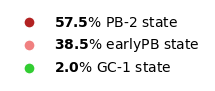

In [53]:
# Create custom legend handles and labels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster at bottom
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-4': 'mediumorchid',     # purple cluster
    'GC-1': 'limegreen',          # bright green cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'Naive': 'darkgray',          # gray cluster on left
    'GC-2': 'green',              # darker green cluster
    'PB-2': 'firebrick',          # red cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'earlyActB': 'teal'           # teal cluster
}
# Create custom legend handles and labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=leiden_color_dict[state[0]], 
           markersize=8, label=f'$\\mathbf{{{state[1][0]*100:.1f}}}$% {state[0]} state')
    for state in sorted_states
]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 2))  # Adjusted figure size for vertical layout
ax.set_visible(False)  # Hide the axis

# Add the legend to the figure vertically
fig.legend(handles=legend_elements, 
          loc='center', 
          ncol=1,  # Changed to 1 column for vertical layout
          frameon=False)
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/legend_w135.pdf', 
            bbox_inches='tight',  # Ensures the legend isn't cut off
            dpi=300,             # High resolution
            format='pdf')


#### Branch specific animations

In [32]:
branches={
	'Plasmablast':(1,2),
	'Germinal-center':(1,3)
}
#Value range for coloring
vrange={
	'Terminal logFC':[-4,4],
	'Transient logFC':[-4,4],
	'Switching time':[0.0015,0.0045],
}

# for branchname in branches:
# 	print(branchname)
# 	figs=dictys_dynamic_object.draw_discover(*branches[branchname],num=100,dist=0.0005,vrange=vrange)
# 	plt.show()

#### Update dictys object with cell type labels

In [6]:
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/data/clusters.csv'
#read the columns barcodes and cluster
cell_labels_df = pd.read_csv(cell_labels_file)
cell_labels = cell_labels_df['Cluster']
# Convert pandas Series to plain list, removing the index
cell_type_list = cell_labels.values.tolist() if isinstance(cell_labels, pd.Series) else list(cell_labels)
dictys_dynamic_object.prop['c']['color'] = cell_type_list
print(f"Number of cells with color labels: {len(dictys_dynamic_object.prop['c']['color'])}")
print(f"First few labels: {dictys_dynamic_object.prop['c']['color'][:5]}")

Number of cells with color labels: 28494
First few labels: ['GC-1', 'ActB-2', 'ActB-1', 'ActB-1', 'ActB-1']


In [34]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points/equispaced time points), use 100 or higher for finer resolution
nframe=20
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100


In [35]:
branchname='Plasmablast'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['PRDM1']
]
# Select TFs for each row's other plots
tfs_ann=[
	['IRF4','PRDM1','BATF', 'SPIB', 'BACH2']
]
# Select genes to annotate as targets in all rows
target_ann=['RUNX2','MZB1','PRDM1','AFF3', 'IRF4']


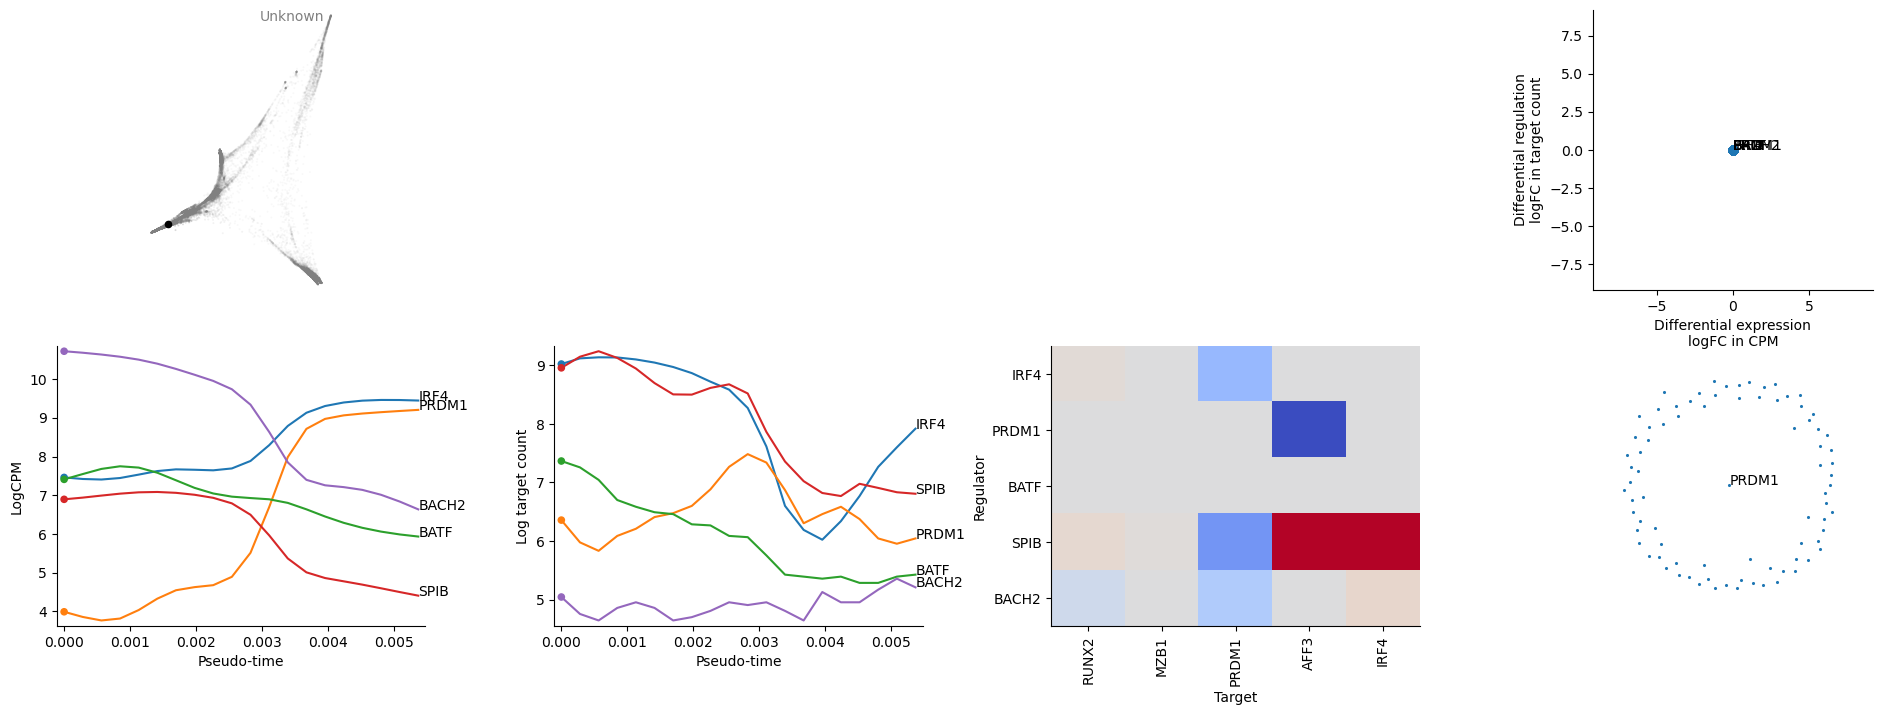

In [36]:
branch=branches[branchname]
# initialize layout with dist, n_points, dpi
layout1=layout.notch(dist=0.0005,nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	dictys_dynamic_object,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)


In [37]:
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='h264')
w.frame_format='jpeg'
fo=f'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/20frames-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))


/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/20frames-Plasmablast.mp4